In [1]:
%load_ext autoreload
%autoreload 2

## Set Up ##

In [ ]:
# prompt: colab mount and direct to current directory

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/romba
!pwd


Mounted at /content/drive
/content/drive/MyDrive/romba
/content/drive/MyDrive/romba


In [ ]:
!pip install git+https://github.com/davidbau/baukit.git

!pip install dataclasses-json

  Cloning https://github.com/davidbau/baukit.git to /tmp/pip-req-build-n3_bk51d
  Running command git clone --filter=blob:none --quiet https://github.com/davidbau/baukit.git /tmp/pip-req-build-n3_bk51d
  Resolved https://github.com/davidbau/baukit.git to commit 9d51abd51ebf29769aecc38c4cbef459b731a36e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.6 MB/s eta 0:00:00
   

In [ ]:
import sys
sys.path.append('../')

import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer
import os

torch.__version__, transformers.__version__, torch.version.cuda

('2.6.0+cu124', '4.50.3', '12.4')

## Dataset Process ##

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("daishinkan002/new-york-times-relation-extraction-dataset")

print("Path to dataset files:", path)

100%|██████████| 9.02M/9.02M [00:00<00:00, 11.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/daishinkan002/new-york-times-relation-extraction-dataset/versions/1


In [ ]:
import os

for f in os.listdir(path+"/dataset"):
    print(f)

import json
data = []

with open(os.path.join(os.path.join(path, "dataset"), "test.json")) as f:
    for line in f:
        data.append(json.loads(line))
print(data[0])  # preview first 2 entries



test.json
train.json
valid.json
{'sentText': 'But that spasm of irritation by a master intimidator was minor compared with what Bobby Fischer , the erratic former world chess champion , dished out in March at a news conference in Reykjavik , Iceland .', 'articleId': '/m/vinci8/data1/riedel/projects/relation/kb/nyt1/docstore/nyt-2005-2006.backup/1677367.xml.pb', 'relationMentions': [{'em1Text': 'Bobby Fischer', 'em2Text': 'Iceland', 'label': '/people/person/nationality'}, {'em1Text': 'Iceland', 'em2Text': 'Reykjavik', 'label': '/location/country/capital'}, {'em1Text': 'Iceland', 'em2Text': 'Reykjavik', 'label': '/location/location/contains'}, {'em1Text': 'Bobby Fischer', 'em2Text': 'Reykjavik', 'label': '/people/deceased_person/place_of_death'}], 'entityMentions': [{'start': 0, 'label': 'PERSON', 'text': 'Bobby Fischer'}, {'start': 1, 'label': 'LOCATION', 'text': 'Reykjavik'}, {'start': 2, 'label': 'LOCATION', 'text': 'Iceland'}], 'sentId': '1'}


In [ ]:
relation_labels = set()
for entry in data:
    for mention in entry.get("relationMentions", []):
        relation_labels.add(mention["label"])

sorted_labels = sorted(relation_labels)
print(f"Found {len(sorted_labels)} unique relation labels:\n")
for label in sorted_labels:
    print(label)


Found 22 unique relation labels:

/business/company/advisors
/business/company/founders
/business/company/major_shareholders
/business/company/place_founded
/business/company_shareholder/major_shareholder_of
/business/person/company
/location/administrative_division/country
/location/country/administrative_divisions
/location/country/capital
/location/location/contains
/location/neighborhood/neighborhood_of
/people/deceased_person/place_of_death
/people/ethnicity/geographic_distribution
/people/ethnicity/people
/people/person/children
/people/person/ethnicity
/people/person/nationality
/people/person/place_lived
/people/person/place_of_birth
/people/person/religion
/sports/sports_team/location
/sports/sports_team_location/teams


In [ ]:
import json
import random
from collections import defaultdict

# Define factual relations + corresponding templates
relation_templates = {
    "/location/country/capital": "The capital of {} is the city of",
    "/location/location/contains": "{} is located in the city of",
    "/people/person/nationality": "{} is a citizen of",
    "/people/person/place_of_birth": "{} was born in",
    "/business/company/founders": "{} was founded by",
    "/people/person/children": "{} is the parent of"
}

max_examples_per_relation = 25  # how many per class

# Flatten into (s, r, o) triples
grouped_triples = defaultdict(list)
for entry in data:
    for mention in entry.get("relationMentions", []):
        label = mention["label"]
        if label in relation_templates:
            s = mention["em1Text"]
            o = mention["em2Text"]
            grouped_triples[label].append((s, o))

# Downsample and format
final_prompts = []
for label, examples in grouped_triples.items():
    sampled = random.sample(examples, min(max_examples_per_relation, len(examples)))
    template = relation_templates[label]
    for s, o in sampled:
        final_prompts.append({
            "prompt_template": template,
            "prompt": template.format(s),
            "subject": s,
            "target": o,
            "label": label
        })

print(f"Final prompt count: {len(final_prompts)}")

# Save to JSONL
with open("balanced_sampled_prompts.jsonl", "w") as f_out:
    for entry in final_prompts:
        f_out.write(json.dumps(entry) + "\n")

print("Saved to balanced_sampled_prompts.jsonl ✅")


Final prompt count: 150
Saved to balanced_sampled_prompts.jsonl ✅


In [ ]:
label_dict = {}
for entry in final_prompts:
      label = entry['label']
      if label not in label_dict:
          label_dict[label] = []
      label_dict[label].append(entry)

for key in label_dict:
  print((key, len(label_dict[key])))

('/people/person/nationality', 25)
('/location/country/capital', 25)
('/location/location/contains', 25)
('/people/person/children', 25)
('/people/person/place_of_birth', 25)
('/business/company/founders', 25)


## Demo ##

In [ ]:
from src.models import ModelandTokenizer

MODEL_PATH = "state-spaces/mamba-2.8b"
# MODEL_PATH = "EleutherAI/pythia-2.8b-deduped"


mt = ModelandTokenizer(
    model_path=MODEL_PATH,
    torch_dtype=torch.float32
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/11.1G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/457k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

In [ ]:
###################################################
# prompt_template = mt.tokenizer.eos_token + " {} professionally played the sport of"
# subject = "Michael Jordan"
# alt_subject = "Pele"

# prompt_template = mt.tokenizer.eos_token + " {} is located in the city of"
# subject = "Harvard University"
# alt_subject = "Oxford University"

# prompt_template = mt.tokenizer.eos_token + " The headquarter of {} is located in"
# subject = "Microsoft"
# alt_subject = "Google"

# prompt_template = mt.tokenizer.eos_token + " The capital of {} is the city of"
# subject = "Canada"
# alt_subject = "Japan"

# prompt_template = mt.tokenizer.eos_token + " {} originated in the country of"
# subject = "Pizza"
# alt_subject = "Sushi"

# prompt_template = mt.tokenizer.eos_token + " By profession {} was a"
# subject = "Bruce Lee"
# alt_subject = "Harper Lee"

# prompt_template = mt.tokenizer.eos_token + "{} is located in the continent"
# subject = "Metropolitan France"
# alt_subject = "Levski Ridge"

idx = 1

prompt_template = sampled_prompts['data'][idx]["relation"]
subject = sampled_prompts['data'][idx]["subject"]
alt_subject = sampled_prompts['data'][idx]["alt_subject"]

###################################################

FILE_NAME_PREFIX = f"{subject.replace(' ', '_')}"
SAVE_DIR = f"../Figures/causal_tracing_examples"
os.makedirs(SAVE_DIR, exist_ok=True)

prompt = prompt_template.format(subject)


from src.functional import predict_next_token
predict_next_token(
    mt = mt,
    prompt = [
        prompt_template.format(subject) for subject in [subject, alt_subject]
    ]
)

[[PredictedToken(token=' a', prob=0.4409320056438446),
  PredictedToken(token=' the', prob=0.1142469123005867),
  PredictedToken(token=' an', prob=0.06661269068717957),
  PredictedToken(token=' tragedy', prob=0.013235941529273987),
  PredictedToken(token=' his', prob=0.008480103686451912)],
 [PredictedToken(token=' a', prob=0.20846222341060638),
  PredictedToken(token=' the', prob=0.08390694856643677),
  PredictedToken(token=' 18', prob=0.05955661088228226),
  PredictedToken(token=' an', prob=0.0329851470887661),
  PredictedToken(token=' tragedy', prob=0.030461734160780907)]]

In [ ]:
# sampled_prompts['data'][idx]["relation"] = "{} is located in the continent of"
print(prompt_template)
print(sampled_prompts['data'][idx])


{}'s life ended in
{'relation': "{}'s life ended in", 'relation_prefix': '', 'relation_suffix': "{}'s life ended in", 'prompt': "Harold Sakata's life ended in", 'relation_id': 'P20', 'target_false_id': 'Q84', 'target_true_id': 'Q18094', 'target_true': ' Honolulu', 'target_false': ' London', 'subject': 'Harold Sakata', 'category': 'factual', 'alt_subject': 'Robert Colquhoun'}


In [ ]:
from src.tracing import calculate_hidden_flow
from src.plotting import plot_trace_heatmap

indirect_effects = calculate_hidden_flow(
    mt = mt,
    prompt = prompt_template,
    subject = subject,
    alt_subject = alt_subject,
    # subject = alt_subject,
    # alt_subject = subject
)

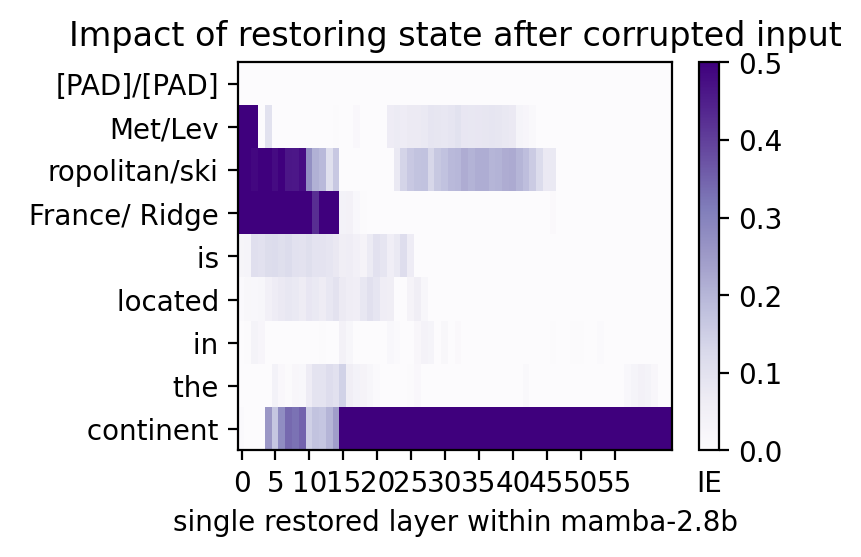

In [ ]:
plot_trace_heatmap(
    indirect_effects,
    modelname=MODEL_PATH.split("/")[-1],
    relative_recovery=True,
    savepdf=os.path.join(SAVE_DIR, f"{FILE_NAME_PREFIX}_res.pdf"),
    scale_range=(0, 0.5)
)

In [ ]:
# for mamba_block_hook in get_args(MambaBlock_Hook_Points):
for mamba_block_hook in [
    "mlp_after_silu",
    "after_down_proj",
    "ssm_after_ssm",
]:
    print("-"*80)
    print(f"{mamba_block_hook=}")
    mt.reset_forward()
    indirect_effects = calculate_hidden_flow(
        mt = mt,
        prompt = prompt_template,
        subject = subject,
        alt_subject = alt_subject,
        mamba_block_hook=mamba_block_hook
    )
    plot_trace_heatmap(
        indirect_effects,
        modelname=MODEL_PATH.split("/")[-1],
        relative_recovery=True,
        savepdf=os.path.join(SAVE_DIR, f"{FILE_NAME_PREFIX}_{mamba_block_hook.split('_')[0]}.pdf"),
        scale_range=(0, 0.5)
    )

In [ ]:
# plot_trace_heatmap(
#     indirect_effects,
#     modelname=MODEL_PATH.split("/")[-1],
#     relative_recovery=True,
#     # savepdf=os.path.join(SAVE_DIR, f"{FILE_NAME_PREFIX}_{mamba_block_hook.split('_')[0]}.pdf"),
#     # scale_range=(0, 0.5)
# )

In [ ]:
# from src.tracing import calculate_hidden_flow
# from src.plotting import plot_trace_heatmap

# prompt_template = mt.tokenizer.eos_token + " {} is located in the city of"

# subject = "The Space Needle"
# prompt = prompt_template.format(subject)

# indirect_effects = calculate_hidden_flow(
#     mt = mt,
#     prompt = prompt,
#     subject = subject,
# )
# plot_trace_heatmap(indirect_effects, modelname=MODEL_PATH.split("/")[-1])

In [ ]:
# from src.hooking.mamba import MambaBlock_Hook_Points
# from typing import get_args

# for mamba_block_hook in get_args(MambaBlock_Hook_Points):
#     print("-"*80)
#     print(f"{mamba_block_hook=}")
#     mt.reset_forward()
#     indirect_effects = calculate_hidden_flow(
#         mt = mt,
#         prompt = prompt,
#         subject = subject,
#         mamba_block_hook=mamba_block_hook
#     )
#     plot_trace_heatmap(indirect_effects, modelname=MODEL_PATH.split("/")[-1])

In [ ]:
# for kind in ["mlp", "attn"]:
#     print("-"*80)
#     print(f"{kind=}")
#     mt.reset_forward()
#     indirect_effects = calculate_hidden_flow(
#         mt = mt,
#         prompt = prompt,
#         subject = subject,
#         alt_subject=alt_subject,
#         kind=kind
#     )
#     plot_trace_heatmap(indirect_effects, modelname=MODEL_PATH.split("/")[-1])

## Experiments ##

In [ ]:
import json
import os

# with open("balanced_sampled_prompts.jsonl") as f:
#     sampled_prompts = [json.loads(line) for line in f]

# print(f"Loaded {len(sampled_prompts)} sampled prompts.")
# print(sampled_prompts[0])  # preview first entry

with open("filtered_counterfact_sample.json", 'r') as f:
  sampled_prompts = json.load(f)

print(f"Loaded {len(sampled_prompts)} sampled prompts.")
print(sampled_prompts['data'][0].keys())  # preview first entry

Loaded 1 sampled prompts.
dict_keys(['relation', 'relation_prefix', 'relation_suffix', 'prompt', 'relation_id', 'target_false_id', 'target_true_id', 'target_true', 'target_false', 'subject', 'category', 'alt_subject'])


In [ ]:
from src.models import ModelandTokenizer

MODEL_PATH = "state-spaces/mamba-2.8b"
# MODEL_PATH = "EleutherAI/pythia-2.8b-deduped"


mt = ModelandTokenizer(
    model_path=MODEL_PATH,
    torch_dtype=torch.float32
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/11.1G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/457k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

In [ ]:
from src.tracing import calculate_hidden_flow
from src.plotting import plot_trace_heatmap
from tqdm import tqdm

In [ ]:
# # Get prompts
# relation_templates = {
#     "/location/country/capital": "The capital of {} is the city of",
#     "/location/location/contains": "{} is part of",
#     "/people/person/nationality": "{} is a citizen of",
#     "/people/person/place_of_birth": "{} was born in",
#     "/business/company/founders": "{} was founded by",
#     "/people/person/children": "{} is the parent of"
# }

# prompts = []
# for entry in sampled_prompts:
#     prompt_template = mt.tokenizer.eos_token + relation_templates[entry["label"]]
#     prompt = (prompt_template, entry['subject'], entry['target'], entry['label'])
#     prompts.append(prompt)

prompts = []

for entry in sampled_prompts['data']:
    prompt_template = mt.tokenizer.eos_token + entry['relation']
    prompt = (prompt_template, entry['subject'], entry['alt_subject'], entry['category'], entry['relation_prefix'], entry['relation_suffix'])
    prompts.append(prompt)

In [ ]:
prompts[0]

('<|endoftext|>{} is located in the continent of',
 'Metropolitan France',
 'Victor Bay',
 'factual',
 '',
 '{} is located in the continent')

In [ ]:
SAVE_DIR = f"../Figures/causal_tracing_examples"
os.makedirs(SAVE_DIR, exist_ok=True)

results = []
SAVE_ROOT = "results"  # or use os.getcwd() + "/results"


for prompt_template, subject, alt_subject, category, relation_prefix, relation_suffix in tqdm(prompts):
  for mamba_block_hook in [
      "after_down_proj"
  ]:
      # print("-"*80)
      # print(f"{mamba_block_hook=}")
      # print(prompt_template)
      # print(subject)
      # print(alt_subject)
      mt.reset_forward()
      indirect_effects = calculate_hidden_flow(
          mt = mt,
          prompt = prompt_template,
          subject = subject,
          alt_subject = alt_subject,
          mamba_block_hook=mamba_block_hook
      )
      indirect_effects["category"] = category
      indirect_effects["subject"] = subject
      indirect_effects["alt_subject"] = alt_subject
      indirect_effects['relation_prefix'] = relation_prefix
      indirect_effects['relation_suffix'] = relation_suffix


      # Create directory
      save_dir = os.path.join(SAVE_ROOT, mamba_block_hook)
      os.makedirs(save_dir, exist_ok=True)


      file_name = f"{subject}__{alt_subject}.json"
      file_path = os.path.join(save_dir, file_name)

      serializable = {
            k: v.tolist() if hasattr(v, "tolist") else v
            for k, v in indirect_effects.items()
        }
      with open(file_path, "w") as f:
            json.dump(serializable, f, indent=4)

      results.append(indirect_effects)


  0%|          | 0/152 [00:00<?, ?it/s]

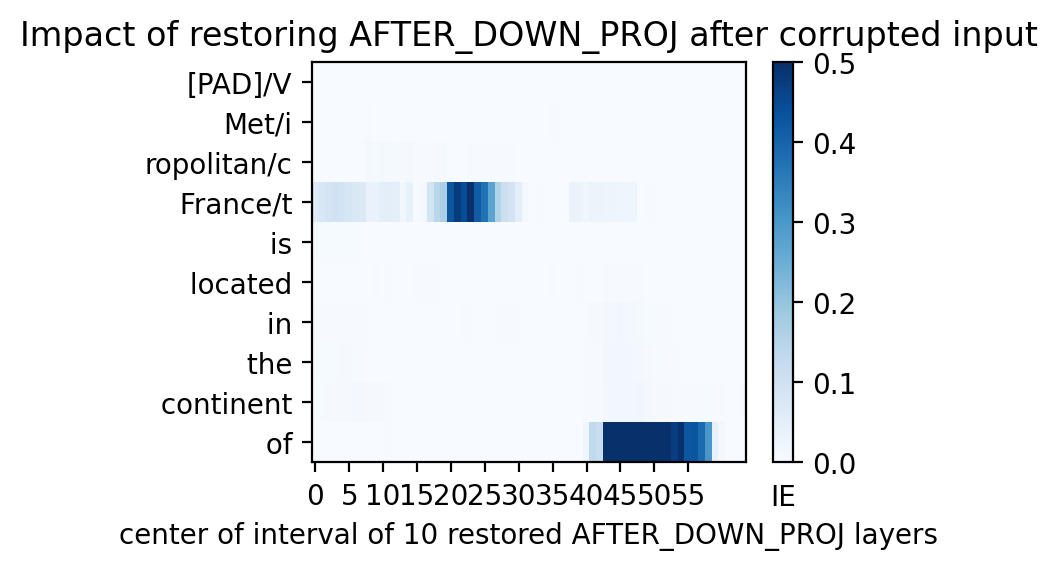

In [ ]:
FILE_NAME_PREFIX = f"{subject.replace(' ', '_')}"

plot_trace_heatmap(
    results[0],
    modelname=MODEL_PATH.split("/")[-1],
    relative_recovery=True,
    savepdf=os.path.join(SAVE_DIR, f"{FILE_NAME_PREFIX}_res.pdf"),
    scale_range=(0, 0.5)
)

In [ ]:
def bin_token_indices(input_tokens, subject_range):
    start, end = subject_range
    T = len(input_tokens)
    bins = {
        "prefix": list(range(0, start)),
        "subject_[:-2]*": list(range(start, max(start, end-2))),
        "subject_2nd_last*": [end - 2] if end - start >= 2 else [],
        "subject_last*": [end - 1],
        "further tokens": list(range(end, T - 1)),
        "last token": [T - 1],
    }
    return bins

In [ ]:
import torch
from collections import defaultdict
from collections import defaultdict

group_scores = defaultdict(list)  # key: (group, layer), value: list of IE values

# Initialize accumulators
group_names = ["prefix", "subject_[:-2]*", "subject_2nd_last*", "subject_last*", "further tokens", "last token"]
group_sums = {g: [] for g in group_names}


for result in results:
    scores = result["scores"]  # shape: [num_layers, num_tokens]
    bins = bin_token_indices(result["input_tokens"], result["subject_range"])

    print((bins, result['input_tokens']))

    for group, token_idxs in bins.items():
        for token_idx in token_idxs:
            for layer in range(scores.shape[0]):
                ie = scores[layer, token_idx].item()
                group_scores[(group, layer)].append(ie)



({'prefix': [0, 1, 2, 3], 'subject_[:-2]*': [], 'subject_2nd_last*': [4], 'subject_last*': [5], 'further tokens': [6, 7, 8], 'last token': [9]}, ['[PAD]', '[PAD]', 'The', ' capital', ' of', ' Jordan', ' is', ' the', ' city', ' of'])
({'prefix': [], 'subject_[:-2]*': [0], 'subject_2nd_last*': [1], 'subject_last*': [2], 'further tokens': [3, 4, 5, 6, 7], 'last token': [8]}, ['[PAD]', 'It', 'aly', ' is', ' located', ' in', ' the', ' city', ' of'])
({'prefix': [], 'subject_[:-2]*': [0, 1, 2, 3, 4, 5], 'subject_2nd_last*': [6], 'subject_last*': [7], 'further tokens': [8, 9, 10], 'last token': [11]}, ['[PAD]', 'Mah', 'm', 'oud', ' Ahmad', 'ine', 'j', 'ad', ' is', ' a', ' citizen', ' of'])
({'prefix': [], 'subject_[:-2]*': [0, 1], 'subject_2nd_last*': [2], 'subject_last*': [3], 'further tokens': [4, 5, 6, 7, 8], 'last token': [9]}, ['[PAD]', '[PAD]', 'Pen', 'nsylvania', ' is', ' located', ' in', ' the', ' city', ' of'])
({'prefix': [], 'subject_[:-2]*': [0, 1], 'subject_2nd_last*': [2], 'subj

In [ ]:
avg_group_scores = [(group, layer, torch.tensor(scores).mean().item()) for (group, layer), scores in group_scores.items()]

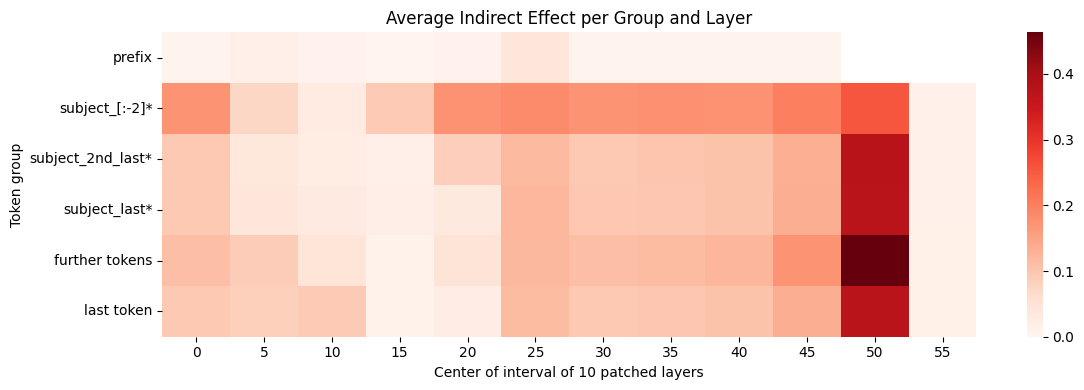

In [ ]:
import numpy as np
score_dict = defaultdict(list)
for group, layer, score in avg_group_scores:
    score_dict[(group, layer)].append(score)

# Determine dimensions
group_names = [
    "prefix",
    "subject_[:-2]*",
    "subject_2nd_last*",
    "subject_last*",
    "further tokens",
    "last token",
]
max_layer = max(l for _, l, _ in avg_group_scores)
num_layers = max_layer + 1
num_groups = len(group_names)

# Build group → row index map
group_to_row = {g: i for i, g in enumerate(group_names)}

# Fill the matrix
heatmap = np.full((num_groups, num_layers), np.nan)  # NaN means missing

for (group, layer), values in score_dict.items():
    row = group_to_row[group]
    heatmap[row, layer] = np.mean(values)

# You can now plot this using seaborn or matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 4))
sns.heatmap(heatmap, cmap="Reds", xticklabels=[5 * i for i in range(heatmap.shape[1])], yticklabels=group_names, vmin=0.0, vmax=np.nanmax(heatmap))
plt.xlabel("Center of interval of 10 patched layers")
plt.ylabel("Token group")
plt.title("Average Indirect Effect per Group and Layer")
plt.tight_layout()
plt.show()
